In [1]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

In [113]:
df = pd.read_csv('data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.index = df.timestamp
del df['tot_rate']
del df['timestamp']
df.columns = ['level', 'rain']
print df.shape
df = df[10000:50000]
df.head()

(286272, 2)


,level,rain
timestamp,,
2008-04-14 04:00:00,0.369,0.0
2008-04-14 04:15:00,0.368,0.0
2008-04-14 04:30:00,0.368,0.0
2008-04-14 04:45:00,0.367,0.0
2008-04-14 05:00:00,0.366,0.0


# Linear regression using rain only

In [3]:
# 100 equates to roughly 24 hours
n_features = 1000
y_train = df.level[n_features:].values
y_train = np.reshape(y_train, (y_train.shape[0], 1)).astype('float32')

In [4]:


x_train = df[['rain']].copy()
for i in range(1, n_features):
    x_train['rain' + str(i)] = x_train['rain'].shift(i)
x_train = x_train[n_features:].values.astype('float32')

In [5]:
# Add bias terms...
n_training_samples = x_train.shape[0]
x_train = np.reshape(np.c_[np.ones(n_training_samples),x_train],[n_training_samples,n_features + 1])

In [6]:
from sklearn import linear_model

In [7]:
reg = linear_model.LinearRegression()

In [8]:
reg.fit(x_train, y_train)

/Users/Conn/.pyenv/versions/democracy/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

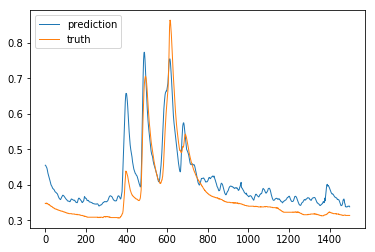

In [9]:
fig, ax = plt.subplots( nrows=1, ncols=1)  # create figure & 1 axis

#ax.plot(0.4 + df.rain.values[:1500]/10, linewidth=.5)

ax.plot(reg.predict(x_train)[:1500],  label='prediction', linewidth=1)
ax.plot(y_train[:1500],  label='truth', linewidth=1)
plt.legend()
plt.savefig('foo.png')
plt.legend(loc='upper left')

In [10]:
print "Mean squared error: %.2f" % np.mean((reg.predict(x_train) - y_train) ** 2)

Mean squared error: 0.01


In [11]:
print 'Variance score: %.2f' % reg.score(x_train, y_train)


Variance score: 0.81


In [12]:
from sklearn.metrics import explained_variance_score, r2_score

In [13]:
# New model
print explained_variance_score(y_train, reg.predict(x_train))
print r2_score(y_train, reg.predict(x_train))

0.814740841583
0.814740847116


In [14]:
weights_sk = reg.coef_

In [15]:
bias_sk = reg.intercept_

In [16]:
bias_sk

array([ 0.31534036])

# Can we update rain from level?

$W \times x = y$ 

$[1+n-a, n]\times[n, 1]=[1+n-a, 1]$

$X \times w = y$

$[1+n-a, a]\times[a, 1]=[1+n-a, 1]$

In [98]:
# a - number of features. 100 equates to roughly 24 hours
a = n_features
# number of samples
s = n_features + 1500

nxt = 200


In [99]:
# vector of rain values
x = df.rain[:s].values
x = np.reshape(x, (x.shape[0], 1)).astype('float32')

#
X = df[['rain']][:s].copy()
for i in range(1, a):
    X['rain' + str(i)] = X['rain'].shift(i)
X = X[a - 1:].values.astype('float32')
print x.shape
print X.shape

x_next = df.rain[s:s+nxt].values
x_next = np.reshape(x_next, (x_next.shape[0], 1)).astype('float32')


(2500, 1)
(1501, 1000)


In [100]:
y = df.level[a-1:s].values
y = np.reshape(y, (y.shape[0], 1)).astype('float32')

y_next = df.level[s:s+nxt].values
y_next = np.reshape(y_next, (y_next.shape[0], 1)).astype('float32')
print y.shape


(1501, 1)


In [101]:
w = weights_sk[:,1:]

b = bias_sk
# repeat vector W
W = np.repeat(np.flip(w, axis=1), 1+s-a, axis=0)
# add zeros as padding
W = np.pad(W,((0,0),(0,s-a)), mode='constant')

# Shift rows
rows, column_indices = np.ogrid[:W.shape[0], :W.shape[1]]
r = np.array(range(0, W.shape[0]))

r[r < 0] += W.shape[1]
column_indices = column_indices - r[:,np.newaxis]

W = W[rows, column_indices]
#print w.shape
print W.shape


W_next = np.repeat(np.flip(w, axis=1), 1+s-a+nxt, axis=0)
# add zeros as padding
W_next = np.pad(W_next,((0,0),(0,s-a)), mode='constant')

# Shift rows
rows, column_indices = np.ogrid[:W_next.shape[0], :W_next.shape[1]]
r = np.array(range(0, W_next.shape[0]))

r[r < 0] += W_next.shape[1]
column_indices = column_indices - r[:,np.newaxis]

W_next = W_next[rows, column_indices]


(1501, 2500)


In [102]:
# check that W*x ~= X*w
sum((np.matmul(W, x)) - (np.matmul(X, w.T)))


array([ -1.04083409e-15])

In [103]:
from scipy.optimize import nnls

x_cal = nnls(W, (y - bias_sk)[:,0])[0]
x_cal.shape

(2500,)

In [104]:
print explained_variance_score(y, (np.matmul(W, x_cal) + bias_sk))


0.964304003903


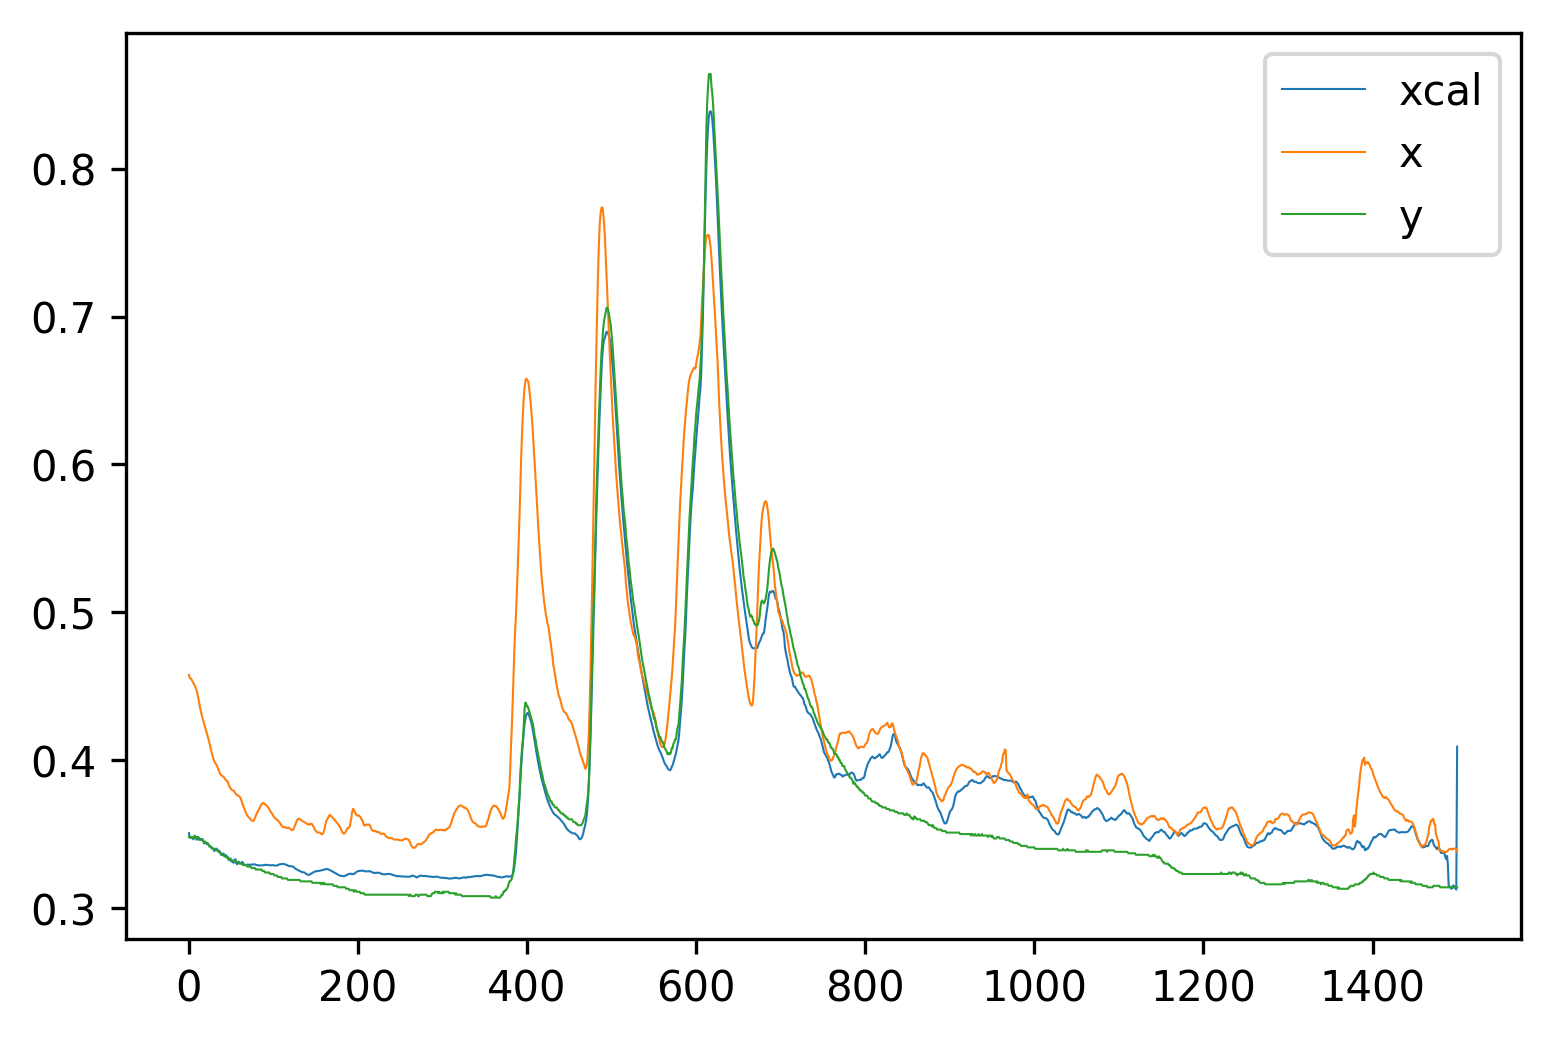

In [105]:
fig, ax = plt.subplots(dpi=300)


ax.plot((np.matmul(W, x_cal) + bias_sk), label='xcal', linewidth=.5)
ax.plot(np.matmul(W, x) + bias_sk, label='x', linewidth=.5)

ax.plot(y, label='y', linewidth=.5)
plt.legend()
plt.show()

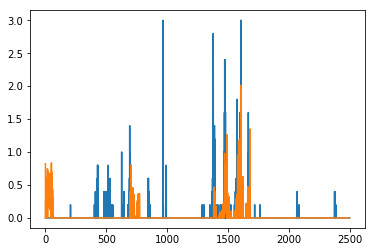

In [107]:
plt.plot(x)
plt.plot(x_cal[:-12])

# Now let's try recreating the model - with level update at 4am every day

* At 4am backcalculate what the rain 'should' have been for the previous 

In [121]:
df1 = pd.read_csv('data.csv')
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
del df1['tot_rate']

df1.columns = ['timestamp', 'level', 'rain']
df1 = df1[10000:50000].reset_index()
del df1['index']
df1.head()

,timestamp,level,rain
0,2008-04-14 04:00:00,0.369,0.0
1,2008-04-14 04:15:00,0.368,0.0
2,2008-04-14 04:30:00,0.368,0.0
3,2008-04-14 04:45:00,0.367,0.0
4,2008-04-14 05:00:00,0.366,0.0


In [135]:
print w[0, :].shape
print rain_.shape
np.matmul(w[0, :].T, rain_)

(1000,)
(1000,)


0.040117685819527703

In [242]:
predict = []
predict2 = []

df1['rain_cal'] = df1['rain']

for index, row in df1[5000:8000].iterrows():
    predict.append(np.matmul(w[0, :].T, np.flip(df1['rain'][index-a:index], axis=0))+bias_sk)

    if (row.timestamp.hour == 4) & (row.timestamp.minute == 0):
        print index
        rain_ = df1['rain'][index-s:index].values
        level_ = df1['level'][index+a-s-1:index].values
        level2_ = np.concatenate((rain_[:a] + bias_sk, level_))
        rain_cal = nnls(W_, (level2_ - bias_sk))[0]
        df1.loc[index-s+1:index-12,'rain_cal'] = rain_cal[:-12]
    
    predict2.append(np.matmul(w[0, :].T, np.flip(df1['rain_cal'][index-a:index], axis=0))+bias_sk)


5088
5184
5280
5376
5472
5568
5664
5760
5856
5952
6048
6144
6240
6336
6432
6528
6624
6720
6816
6912
7008
7104
7200
7296
7392
7488
7584
7680
7776
7872
7968


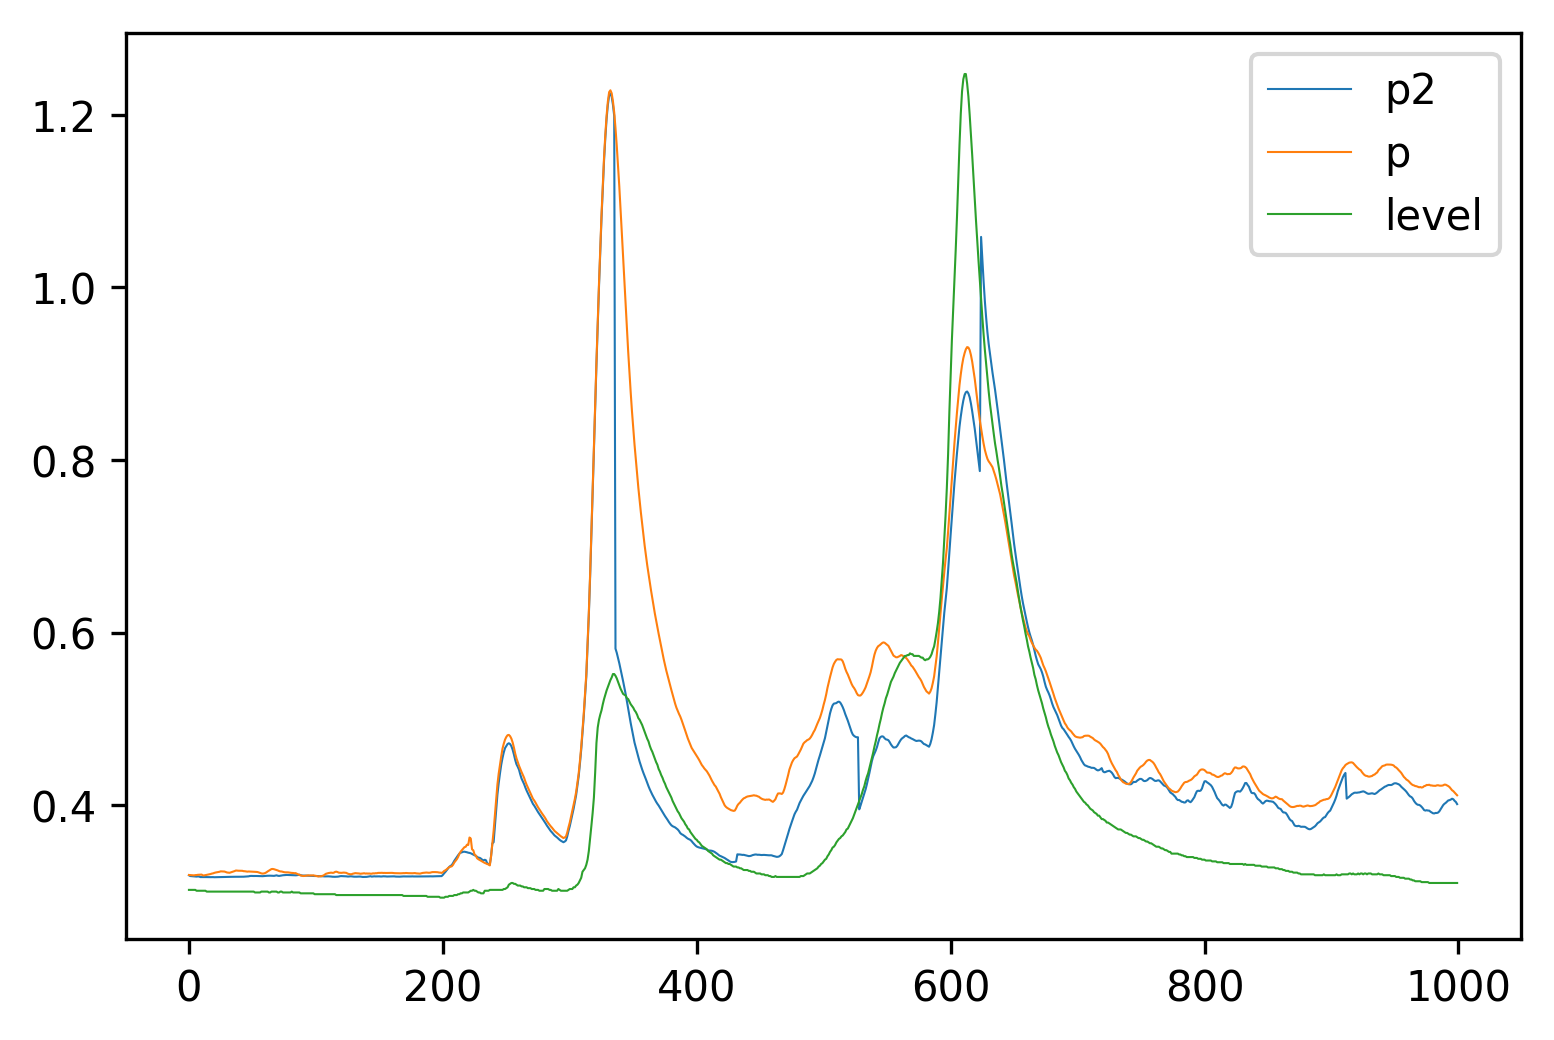

In [248]:
fig, ax = plt.subplots(dpi=300)



ax.plot(predict2[1000:2000], label='p2', linewidth=.5)
ax.plot(predict[1000:2000], label='p', linewidth=.5)
ax.plot(df1[6000:7000].reset_index()['level'], label='level', linewidth=.5)


plt.legend()

plt.show()

In [245]:
print explained_variance_score(df1[5000:8000].reset_index()['level'], predict)
print explained_variance_score(df1[5000:8000].reset_index()['level'], predict2)


0.823074051005
0.843449128665


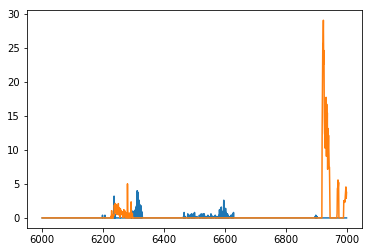

In [230]:
plt.plot(df1.rain[6000:7000])
plt.plot(df1.rain_cal[6000:7000])


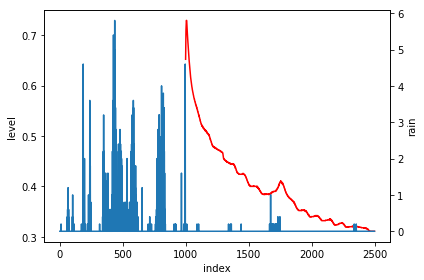

In [231]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('index')


ax1.plot(np.concatenate((np.nan*np.empty(a-1),level_),axis=0), 'r')
ax1.set_ylabel('level')

ax2 = ax1.twinx()
ax2.plot(rain_)


ax2.set_ylabel('rain')

fig.tight_layout()
plt.show()

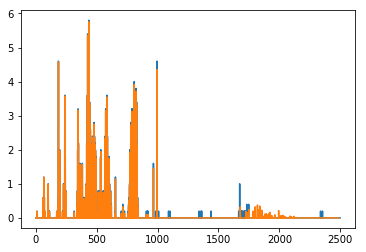

In [241]:
plt.plot(rain_)
plt.plot(rain_cal[:-12])

In [240]:
level2_ = np.concatenate((rain_[:a] + bias_sk, level_))

rain_cal = nnls(W_, (level2_ - bias_sk))[0]


# Idea for adding extra rows to W to create W_

In [234]:
temp = np.zeros((a, s), float)
np.fill_diagonal(temp, 1)

W_ = np.concatenate((temp, W))
print W.shape
print W_.shape

(1501, 2500)
(2501, 2500)


In [235]:
y_ = np.concatenate((x[:a] + bias_sk, y))

print y_.shape

(2501, 1)


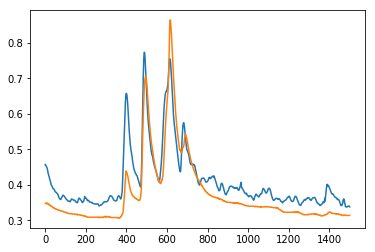

In [236]:
plt.plot((np.matmul(W_, x) + bias_sk)[a:])
plt.plot(y_[a:])

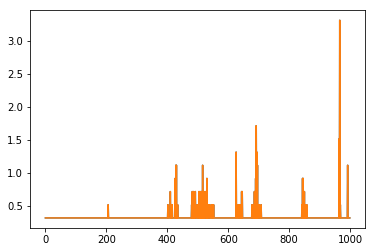

In [237]:
plt.plot((np.matmul(W_, x) + bias_sk)[:a])
plt.plot(y_[:a])

In [26]:
from scipy.optimize import nnls

x_cal_ = nnls(W_, (y_ - bias_sk)[:,0])[0]
x_cal_.shape

(5000,)

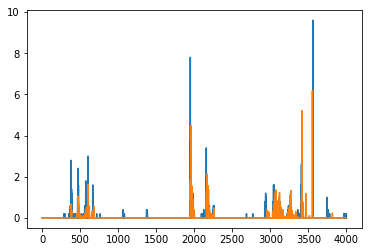

In [35]:
plt.plot(x[a:])
plt.plot(x_cal_[a:-12])

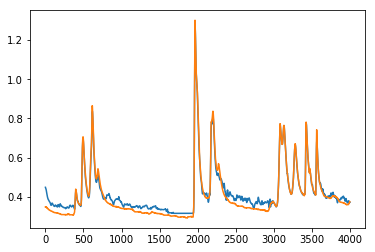

In [28]:
plt.plot((np.matmul(W_, x_cal_) + bias_sk)[a:])
plt.plot(y)

In [39]:
print explained_variance_score(y, np.matmul(W, x) + bias_sk)


0.817083128714


In [40]:
print explained_variance_score(y, (np.matmul(W_, x_cal_) + bias_sk)[a:])


0.973851496125
